# Classification with Vision Transformer (ViT) with fine tuning on MNIST

In this tutorial, we will use the HuggingFace API.

### Import python modules

In [3]:
import numpy as np
import torch, os
from datasets import load_dataset
from keras.datasets import mnist
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)

import warnings
warnings.filterwarnings("ignore")

# To not use the GPU
os.environ["CUDA_VISIBLE_DEVICES"]=""

### Load MNIST dataset (from HuggingFace's hub)

In [5]:
train_ds, test_ds = load_dataset('mnist', split=['train', 'test'])

# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

Found cached dataset mnist (/home/tbetton/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 95.75it/s]


In [7]:
print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 48000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 12000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})


In [8]:
train_ds.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

In [9]:
train_ds[0]['image']

A simple mapping between an id and its label (data type difference)

In [10]:
id2label = {id: label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label: id for id, label in id2label.items()}
label2id

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

## Preprocessing the data

We preprocess our data using the preprocessor of our model (google/vit). This allows us to resize our images, switch them to RGB format and normalise them.

In [11]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)


def transforms(examples):
    examples['pixel_values'] = [_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [12]:
# Set the transforms
train_ds.set_transform(transforms)
val_ds.set_transform(transforms)
test_ds.set_transform(transforms)

Plot an image after preprocessing. We can see some blur due to resizing.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


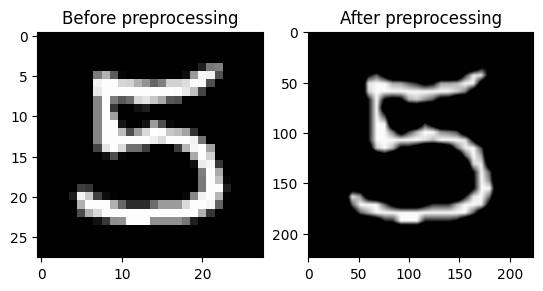

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(train_ds[0]["image"], cmap=plt.get_cmap('gray'))
ax1.title.set_text("Before preprocessing")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.transpose(train_ds[0]["pixel_values"], (1, 2, 0)))
ax2.title.set_text("After preprocessing")

## Model

We define a `ViTForImageClassification`, which places a linear layer on top of a pre-trained ViTModel.
This model is pre-trained on ImageNet-21k, a dataset of 14 million labeled images.

In [18]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To fine tune the model, we need to define a `TraningArguments`.

In [19]:
args = TrainingArguments(
    f"test-mnist",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

Some other useful functions for training.

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Finally, here is the trainer.

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

Train the model.

In [22]:
trainer.train()

  3%|▎         | 500/14400 [32:00<11:33:44,  2.99s/it]

{'loss': 0.7662, 'learning_rate': 1.9305555555555558e-05, 'epoch': 0.1}


  7%|▋         | 1000/14400 [58:52<12:29:08,  3.35s/it]

{'loss': 0.1559, 'learning_rate': 1.8611111111111114e-05, 'epoch': 0.21}


 10%|█         | 1500/14400 [1:25:46<12:56:07,  3.61s/it]

{'loss': 0.0875, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}


 14%|█▍        | 2000/14400 [1:53:25<11:15:57,  3.27s/it]

{'loss': 0.0775, 'learning_rate': 1.7222222222222224e-05, 'epoch': 0.42}


 17%|█▋        | 2500/14400 [2:20:48<12:03:12,  3.65s/it]

{'loss': 0.0532, 'learning_rate': 1.6527777777777777e-05, 'epoch': 0.52}


 21%|██        | 3000/14400 [2:48:16<9:51:05,  3.11s/it] 

{'loss': 0.0515, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


 24%|██▍       | 3500/14400 [3:16:00<10:54:41,  3.60s/it]

{'loss': 0.0412, 'learning_rate': 1.513888888888889e-05, 'epoch': 0.73}


 28%|██▊       | 4000/14400 [3:42:54<8:37:42,  2.99s/it] 

{'loss': 0.0373, 'learning_rate': 1.4444444444444446e-05, 'epoch': 0.83}


 31%|███▏      | 4500/14400 [4:09:16<8:31:38,  3.10s/it] 

{'loss': 0.0395, 'learning_rate': 1.375e-05, 'epoch': 0.94}


                                                         
 33%|███▎      | 4800/14400 [4:46:02<8:32:47,  3.20s/it]

{'eval_loss': 0.04052659124135971, 'eval_accuracy': 0.99175, 'eval_runtime': 1259.8106, 'eval_samples_per_second': 9.525, 'eval_steps_per_second': 2.381, 'epoch': 1.0}


 35%|███▍      | 5000/14400 [4:56:14<8:18:45,  3.18s/it]    

{'loss': 0.0384, 'learning_rate': 1.3055555555555557e-05, 'epoch': 1.04}


 38%|███▊      | 5500/14400 [5:21:28<7:37:18,  3.08s/it]

{'loss': 0.0257, 'learning_rate': 1.2361111111111113e-05, 'epoch': 1.15}


 42%|████▏     | 6000/14400 [5:46:57<6:50:59,  2.94s/it]

{'loss': 0.023, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


 45%|████▌     | 6500/14400 [6:11:59<6:31:22,  2.97s/it]

{'loss': 0.021, 'learning_rate': 1.0972222222222224e-05, 'epoch': 1.35}


 49%|████▊     | 7000/14400 [6:36:50<6:03:15,  2.95s/it]

{'loss': 0.0201, 'learning_rate': 1.0277777777777777e-05, 'epoch': 1.46}


 52%|█████▏    | 7500/14400 [7:01:57<5:40:37,  2.96s/it]

{'loss': 0.0149, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}


 56%|█████▌    | 8000/14400 [7:26:54<5:13:43,  2.94s/it]

{'loss': 0.0258, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.67}


 59%|█████▉    | 8500/14400 [7:51:44<4:54:13,  2.99s/it]

{'loss': 0.0286, 'learning_rate': 8.194444444444445e-06, 'epoch': 1.77}


 62%|██████▎   | 9000/14400 [8:16:28<4:27:54,  2.98s/it]

{'loss': 0.0238, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 66%|██████▌   | 9500/14400 [8:41:11<4:02:27,  2.97s/it]

{'loss': 0.022, 'learning_rate': 6.8055555555555566e-06, 'epoch': 1.98}


                                                        
 67%|██████▋   | 9600/14400 [9:06:33<3:58:45,  2.98s/it]

{'eval_loss': 0.02248166874051094, 'eval_accuracy': 0.9953333333333333, 'eval_runtime': 1225.3782, 'eval_samples_per_second': 9.793, 'eval_steps_per_second': 2.448, 'epoch': 2.0}


 69%|██████▉   | 10000/14400 [9:26:18<3:37:55,  2.97s/it]  

{'loss': 0.0127, 'learning_rate': 6.111111111111112e-06, 'epoch': 2.08}


 73%|███████▎  | 10500/14400 [9:50:59<3:12:53,  2.97s/it]

{'loss': 0.0081, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.19}


 76%|███████▋  | 11000/14400 [10:15:48<2:49:16,  2.99s/it]

{'loss': 0.0108, 'learning_rate': 4.722222222222222e-06, 'epoch': 2.29}


 80%|███████▉  | 11500/14400 [10:40:37<2:25:36,  3.01s/it]

{'loss': 0.0089, 'learning_rate': 4.027777777777779e-06, 'epoch': 2.4}


 83%|████████▎ | 12000/14400 [11:05:24<1:59:27,  2.99s/it]

{'loss': 0.0063, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 87%|████████▋ | 12500/14400 [11:30:09<1:34:03,  2.97s/it]

{'loss': 0.0101, 'learning_rate': 2.6388888888888893e-06, 'epoch': 2.6}


 90%|█████████ | 13000/14400 [11:54:57<1:09:37,  2.98s/it]

{'loss': 0.0046, 'learning_rate': 1.944444444444445e-06, 'epoch': 2.71}


 94%|█████████▍| 13500/14400 [12:19:42<44:24,  2.96s/it]  

{'loss': 0.005, 'learning_rate': 1.25e-06, 'epoch': 2.81}


 97%|█████████▋| 14000/14400 [12:44:27<19:51,  2.98s/it]

{'loss': 0.0083, 'learning_rate': 5.555555555555555e-07, 'epoch': 2.92}


                                                        
100%|██████████| 14400/14400 [13:24:32<00:00,  2.98s/it]

{'eval_loss': 0.020368274301290512, 'eval_accuracy': 0.9954166666666666, 'eval_runtime': 1214.5232, 'eval_samples_per_second': 9.88, 'eval_steps_per_second': 2.47, 'epoch': 3.0}


100%|██████████| 14400/14400 [13:24:33<00:00,  3.35s/it]

{'train_runtime': 48273.1468, 'train_samples_per_second': 2.983, 'train_steps_per_second': 0.298, 'train_loss': 0.0566790093978246, 'epoch': 3.0}


TrainOutput(global_step=14400, training_loss=0.0566790093978246, metrics={'train_runtime': 48273.1468, 'train_samples_per_second': 2.983, 'train_steps_per_second': 0.298, 'train_loss': 0.0566790093978246, 'epoch': 3.0})

The results are impressive but on one CPU and with only 3 epochs, it took **13.4 hours**!

## Evaluation

Metrics + confusion matrix

100%|██████████| 2500/2500 [19:14<00:00,  2.17it/s] 

{'test_loss': 0.017040256410837173, 'test_accuracy': 0.9966, 'test_runtime': 1154.9515, 'test_samples_per_second': 8.658, 'test_steps_per_second': 2.165}


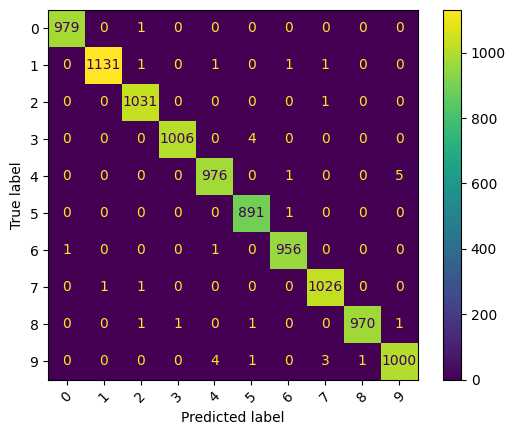

In [23]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

#### Explore errors !

In [24]:
errors = [i for i in range(len(test_ds)) if y_pred[i] != y_true[i]]

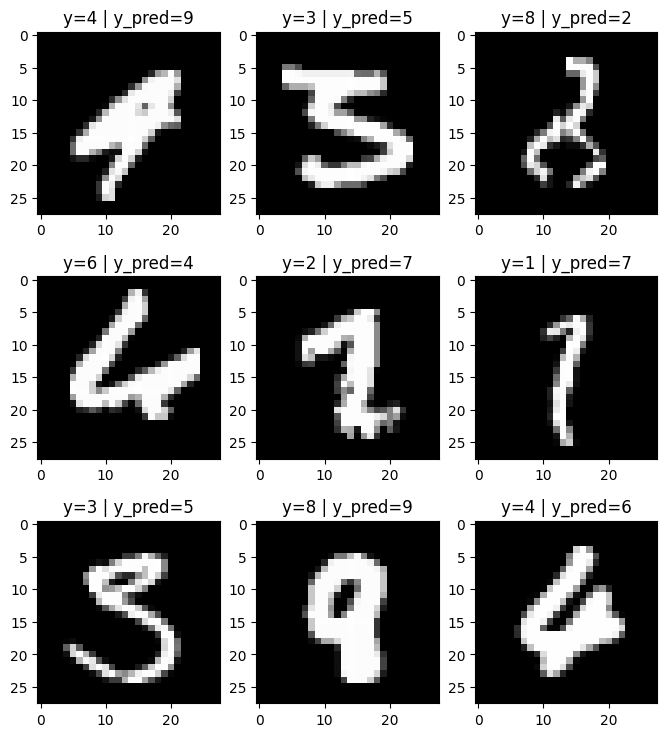

In [25]:
plt.figure(figsize=(8,9))
for i, X_test_index in enumerate(errors[:9]):  
    plt.subplot(3, 3, i+1)
    plt.imshow(test_ds[X_test_index]["image"], cmap=plt.get_cmap('gray'))
    plt.title(f"y={y_true[X_test_index]} | y_pred={y_pred[X_test_index]}")
plt.show()

In [ ]:
torch.save(model, "finetuning_mnist")